In [1]:
using Plots; pyplot();
using Optim
using BenchmarkTools
using Distributions
using LaTeXStrings

In [2]:
#one point in the state space = one column
@inline @views function kernel!(K::Matrix{Float64}, x::Matrix{Float64}, xp::Matrix{Float64}, θ::Vector{Float64})
    @inbounds s = exp(θ[1])
    @inbounds l = exp.(θ[2:length(θ)])
    
    @simd for b in 1:size(xp,2)
        @inbounds K[:, b] = s^2 * exp.(- 1/2 * sum(((x .- xp[:, b]) .^ 2) ./ (l .^ 2), 1)[1, :] )
    end
end

kernel! (generic function with 1 method)

In [3]:
mutable struct LearnedFunction
    Xtrain::Matrix{Float64}
    Ktrain::Matrix{Float64}
    ytrain::Vector{Float64}
    n::Int64
    θ::Vector{Float64}
    L::UpperTriangular{Float64,Array{Float64,2}}
    α::Vector{Float64}
end

function LearnedFunction(Xtrain::Matrix{Float64}, ytrain::Vector{Float64}, θ::Vector{Float64})
    n = size(Xtrain, 2)
    Ktrain = Array{Float64}(n, n)
    kernel!(Ktrain, Xtrain, Xtrain, θ)
    Ktrain = (Ktrain + 0.0001 * eye(n))
    L = chol(Ktrain)
    
    return LearnedFunction(Xtrain, Ktrain, ytrain, n, θ, L, L \ (L' \ ytrain))
end

function update!(fhat::LearnedFunction, θnew::Vector{Float64})
    kernel!(fhat.Ktrain, fhat.Xtrain, fhat.Xtrain, θnew)
    fhat.Ktrain = (fhat.Ktrain + 0.0001 * eye(fhat.n))
    fhat.L = chol(fhat.Ktrain)
    fhat.α = fhat.L \ (fhat.L' \ fhat.ytrain)
    
    fhat.θ = θnew;
end

@inline function loglikelihood(fhat::LearnedFunction)
    return - 1/2 * fhat.ytrain' * fhat.α - 1/2 * sum(log.(diag(fhat.L))) - fhat.n/2 * log(2 * π)
end

function ml(fhat::LearnedFunction)
    obj(θtry) = begin
        update!(fhat, θtry)
        return - loglikelihood(fhat)
    end
    
    result = optimize(obj, fhat.θ, LBFGS())
    
    if !(result.f_converged || result.g_converged || result.x_converged)
        warn("Optimization ended without convergence!")
        println(result)
    end
    
    update!(fhat, result.minimizer)
    
end

@inline function evaluate(fhat::LearnedFunction, Xeval)
    Keval = Array{Float64}(size(Xeval, 2), fhat.n)
    kernel!(Keval, Xeval, fhat.Xtrain, fhat.θ)
    return Keval * fhat.α
end

evaluate (generic function with 1 method)

## 1D Example

In [156]:
f(x) = sin.(x[1, :])

f (generic function with 1 method)

In [157]:
n = 10
Xtrain = 2* π *rand(Uniform(), n, 1)'
ytrain = f(Xtrain);

In [158]:
fhat = LearnedFunction(Xtrain, ytrain, [0., 0]);

In [159]:
@time ml(fhat);

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.0,0.0]
 * Minimizer: [0.6861555013518397,0.8026773296118838]
 * Minimum: 7.394335e-01
 * Iterations: 13
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 56
 * Gradient Calls: 56
  0.003638 seconds (28.13 k allocations: 3.683 MiB)


In [160]:
N = 1000
Xeval = 2 * π * rand(Uniform(), N, 1)';


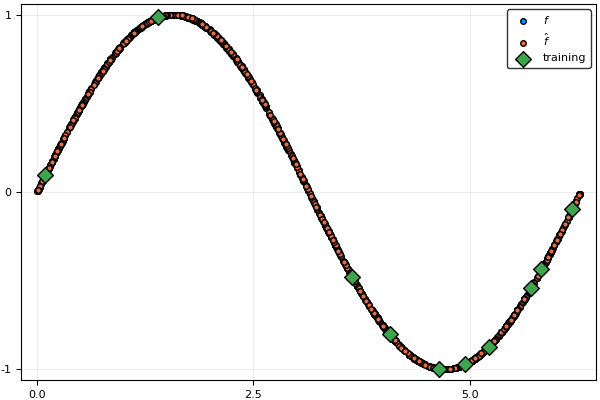

In [161]:
scatter(Xeval[1, :], f(Xeval), label = L"f")
scatter!(Xeval[1, :], evaluate(fhat, Xeval), label = L"\hat{f}")
scatter!(Xtrain[1, :], ytrain, label = "training", markersize = 8, markershape = :diamond)

In [165]:
maximum(abs.( evaluate(fhat, Xeval) - f(Xeval) ))

0.007540636747056628

In [163]:
sqrt(sum((evaluate(fhat, Xeval) - f(Xeval)) .^ 2 ./ f(Xeval) .^ 2)) / N

1.0390920433628321

## 2D Example


In [183]:
f(x) = abs.(0.25 - x[1, :] .^ 2 - x[2, :] .^ 2)

f (generic function with 1 method)

In [202]:
n = 100
Xtrain = rand(Uniform(), n, 2)'
Xtrain[2, :] = (1 - Xtrain[1, :]) .* Xtrain[2, :]
ytrain = f(Xtrain);

In [203]:
fhat = LearnedFunction(Xtrain, ytrain, [0., 0, 0]);

In [204]:
ml(fhat);

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-0.7787747850053187,-1.427995291738198, ...]
 * Minimum: -7.775959e+01
 * Iterations: 12
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 58
 * Gradient Calls: 58


Optimization ended without convergence!


In [205]:
N = 1000
Xeval = rand(Uniform(), N, 2)'
Xeval[2, :] = (1 - Xeval[1, :]) .* Xeval[2, :];


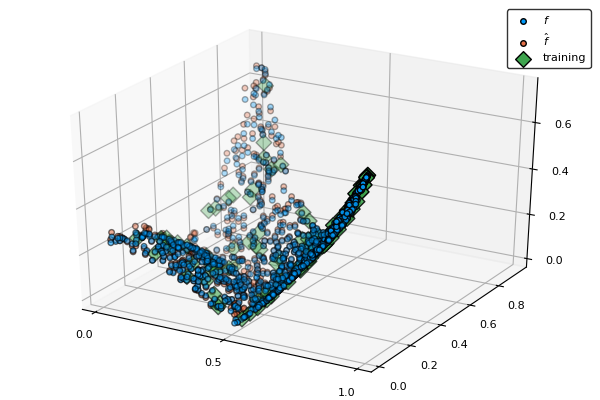

In [206]:
scatter(Xeval[1, :], Xeval[2, :], f(Xeval), label = L"f")
scatter!(Xeval[1, :], Xeval[2, :], evaluate(fhat, Xeval), label = L"\hat{f}")
scatter!(Xtrain[1, :], Xtrain[2, :], ytrain, label = "training", markersize = 8, markershape = :diamond)

In [207]:
maximum(abs.( evaluate(fhat, Xeval) - f(Xeval) ))

0.049641127224566595

In [209]:
sqrt( sum( (evaluate(fhat, Xeval) - f(Xeval)) .^ 2 ./ f(Xeval) .^ 2) ) / N

0.09084346533442672

## Another 2D Example


In [29]:
f(x) = exp.(0.3 * x[1] .+ 0.7 * x[2])

f (generic function with 2 methods)

In [34]:
n = 10
Xtrain = rand(Uniform(), n, 2)'
ytrain = mapslices(f, Xtrain, 1)[1, :];

In [35]:
fhat = LearnedFunction(Xtrain, ytrain, [0., 0, 0]);

In [36]:
ml(fhat);

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [1.7335805791927883,1.7716386222989604, ...]
 * Minimum: -8.096391e-01
 * Iterations: 11
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 43
 * Gradient Calls: 43


In [37]:
N = 1000
Xeval = rand(Uniform(), N, 2)';


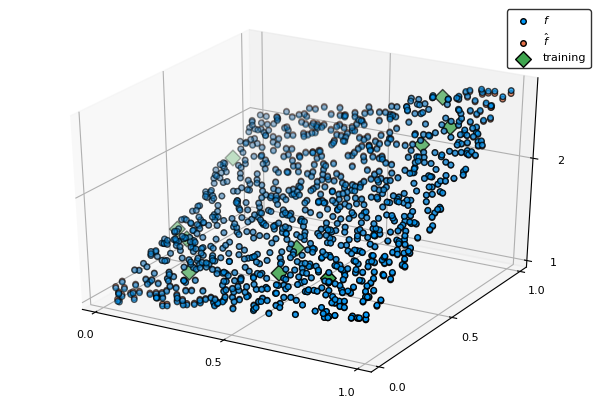

In [40]:
scatter(Xeval[1, :], Xeval[2, :], mapslices(f, Xeval, 1)[1, :], label = L"f")
scatter!(Xeval[1, :], Xeval[2, :], evaluate(fhat, Xeval), label = L"\hat{f}")
scatter!(Xtrain[1, :], Xtrain[2, :], ytrain, label = "training", markersize = 8, markershape = :diamond)

In [41]:
maximum(abs.( evaluate(fhat, Xeval) - mapslices(f, Xeval, 1)[1, :] ))

0.026861823091344217

In [42]:
sqrt( sum( (evaluate(fhat, Xeval) - mapslices(f, Xeval, 1)[1, :]) .^ 2 ./ mapslices(f, Xeval, 1)[1, :] .^ 2) ) / N

0.00012939951053429487

### Active Subspace

In [46]:
g(x) = ForwardDiff.gradient(f, x)

g (generic function with 1 method)

In [48]:
gtrain = mapslices(g, Xtrain, 1);

In [57]:
F = svdfact(gtrain' * gtrain / n);

In [62]:
F[:S]

10-element Array{Float64,1}:
 1.78816    
 9.69194e-17
 7.2425e-17 
 4.9563e-17 
 3.30173e-17
 1.88025e-17
 1.55659e-17
 9.10009e-18
 6.944e-18  
 1.77091e-33